In [1]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning
from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

from statistics import median
from statistics import mode
import math 

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   
3
import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

C:\Users\gleech\Documents\GitHub\kai codes\cluster-analysis\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\cluster-analysis\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\cluster-analysis\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from  matplotlib.animation import FuncAnimation
from matplotlib import cm
import pandas as pd
from pandas import DataFrame, Series  # for convenience

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import pims
import trackpy as tp

import collections
collections.Iterable = collections.abc.Iterable

import yaml
import gc

import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../kai crosslinking (phase 2)/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm
from nd2reader import ND2Reader

from skimage import io 
from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

from numpy.polynomial import Polynomial
import gc

In [28]:
np.set_printoptions(threshold=sys.maxsize)

def rows_n_cols(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    return rows, cols

def show_raw_images(ax, i, frame_key):
    plt.gray()
    date = str(all_files[i].split('\\')[-4][:6])
    slide = str(all_files[i].split('\\')[-2])
    row = str(all_files[i].split('\\')[-1][13:-4])
    test_image = tiff_file.imread(one_time_all[i],key=[frame_key])
    ax.set_title(str(time_array[t_num-1]) + " hrs; "+ date+ ', ' + slide+ ', ' + row, fontsize=10)
    ax.imshow(test_image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(ax, i, frame_key, block_size, offset_val):
    raw_image = tiff_file.imread(one_time_all[i],key=[frame_key])
    ax.set_title(" --> skeletonized", fontsize=10)
    threshold_image = threshold_images(raw_image, block_size, offset_val)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != 1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = 2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == 1:
                array[xcurr-1,ycurr] = 2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == 1:
                array[xcurr+1,ycurr] = 2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == 1:
                array[xcurr,ycurr-1] = 2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == 1:
                array[xcurr,ycurr+1] = 2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize

def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != 2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == 2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == 2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == 2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == 2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))

def threshold_images(image, block_size, offset_val):
    ed_image = (image**0.2)*500
    ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
    #ed_binary_im = (ed_image > ed_thresh)
    #print(ed_binary_im[:2])
    ed_binary_im = 1*(ed_image > ed_thresh)
    #print(ed_binary_im[:2])
    #print(ed_binary_im.shape)
    return ed_binary_im

def zerolistmaker(n):
    listofzeros = ['none found'] * n
    return listofzeros

def cluster_analysis(size_lim, i, row_num, arraythresh, rows, cols):
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == 1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                if clustersize >= size_lim:
                    clusters.append(clustersize)
                    #markcluster_flat(arraythresh,x,y,rows,cols,clustersize)
                    #print("clustersize= %5.3f for (x,y)= (%5.3f, %5.3f)"  %(clustersize,x,y))
                    #print(arraythresh)
                #mark finished cluster with size
                                           #max_size = (max(clusters)) * (pixel_size**2)  
    clusters.sort()
    y_mode = mode(clusters)
    count_of_ymode = clusters.count(y_mode)
    count_at_FW = count_of_ymode*0.01
    
    indexes = []
    for i in range(len(clusters)):
        val = clusters[i]
        if (clusters.count(val) > count_at_FW):
            indexes.append(val)
    FW = (abs(indexes[-1] - indexes[0])) * (pixel_size**2)
    
    total_num = len(clusters)
    mean_size = (sum(clusters) / len(clusters)) * (pixel_size**2)  #pixel size squared b/c max size is an area
    median_size = (median(clusters)) * (pixel_size**2)
    mode_size = (mode(clusters)) * (pixel_size**2)
    
    if (i == 0) and (row_num == 1):
        print(clusters)
    
    #print("for row"+str(row_num)+", t= "+str(time_array[i]) + " hrs:")
    #print('clusters counted: %5i, mean size: %5.3f, median: %5.3f, mode: %5.3f, FW: %5.3f' %(total_num, mean_size, 
     #                                                                                  median_size, mode_size, FW))
    
    return total_num, mean_size, median_size, mode_size, FW, clusters

In [4]:
import math 
clust = [1,2,3,4,5,6,7,3,53,634,567,567,3456,464,65,6,6,5,34,3456,67,6,4,3,554,65,7,544,5,7,7,2,34,42,3,3,23,17,24,5,10,15,20]
#sorted(clust)
clust.sort()
bottom_decile = clust[math.floor(len(clust)/10)]
top_decile = clust[math.floor(9*len(clust)/10)]
FW = top_decile - bottom_decile
print(bottom_decile, top_decile, FW)



3 567 564


<IPython.core.display.Javascript object>


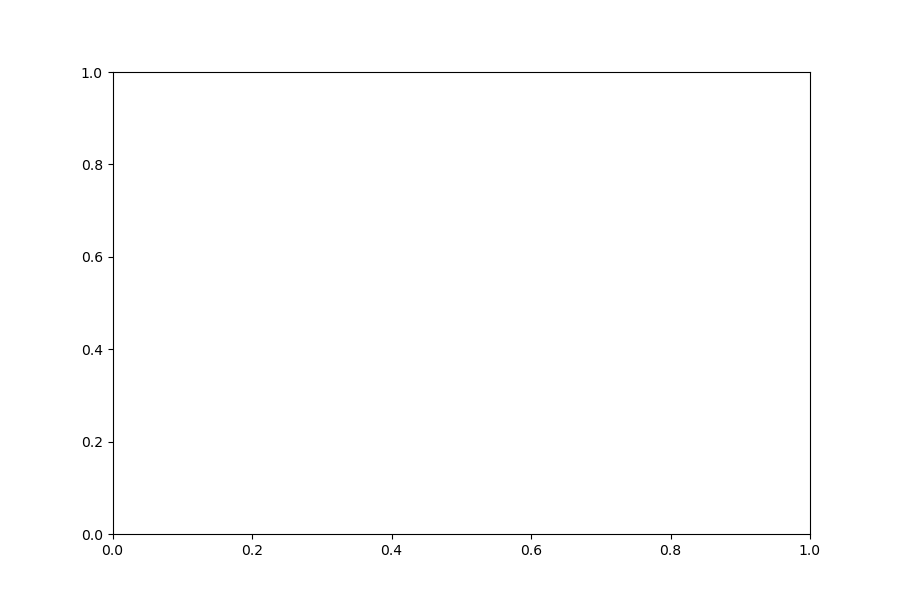

NameError: name 'clusters' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,6))
msize = 0.5

clusters.sort()

y_mode = mode(clusters)
count_of_ymode = clusters.count(y_mode)
count_at_FW = count_of_ymode*0.01

print("y mode= "+ str(y_mode))
print("count of y mode= "+ str(count_of_ymode))
print("1% y mode = " + str(count_at_FW))

indexes = []
for i in range(len(clusters)):
    val = clusters[i]
    if (clusters.count(val) > count_at_FW):
        indexes.append(val)

print("length of clusters list = "+str(len(clusters)))
print("length of indexes = "+str(len(indexes)))
FW = abs(indexes[-1] - indexes[0])
print("FW= " +str(FW))

n, bins = np.histogram(clusters, 100000, density=False)
plt.plot(bins[:-1], n, ms=msize, alpha=0.8, color='b')

ax.set_xscale("log")

ax.axvline(indexes[-1], c='g')
ax.axvline(indexes[0], c='r')
ax.axhline(count_at_FW, c='r')

In [5]:
directory = "Z"
big_exp = "7-8-23 the last Big One"
exp = "all half-x tiff files"  # - normalized
data_dir_s1 = directory+":\\Gregor L\\Kai colloids revisions\\"+big_exp+"\\"+exp+"\\s1\\"
data_dir_s2 = directory+":\\Gregor L\\Kai colloids revisions\\"+big_exp+"\\"+exp+"\\s2\\"
#data_dir_quarterX_s1 = directory+":\\Gregor L\\Kai colloids revisions\\"+exp+"\\all quarter-x tiff files\\s1\\"
#data_dir_quarterX_s2 = directory+":\\Gregor L\\Kai colloids revisions\\"+exp+"\\all quarter-x tiff files\\s2\\"

data_saveto = directory+":\\Gregor L\\Kai colloids revisions\\cluster analysis\\revisions data\\" #bottom_row_t01\\

s1_files = glob.glob(data_dir_s1+"*_t*")  
s2_files = glob.glob(data_dir_s2+"*_t*")  
#files_quarterX_s1 = glob.glob(data_dir_quarterX_s1+"*_t*")  
#files_quarterX_s2 = glob.glob(data_dir_quarterX_s2+"*_t*")  

#print("found %i files" % len(files_95_s1))
#print (' \thalf-x s1 \t\thalf-x s2 \t\tquarter-x s1 \t\t   quarter-x s2')

all_files = []
for i in range(len(s2_files)):
    all_files.append(s1_files[i])
    
for i in range(len(s2_files)):
    all_files.append(s2_files[i])


for i,f in enumerate(all_files): print (' %i \t %s' % (i, f.split('\\')[-1]))

 0 	 half-x_s1_t1_row1.tif
 1 	 half-x_s1_t1_row2.tif
 2 	 half-x_s1_t1_row3.tif
 3 	 half-x_s1_t1_row4.tif
 4 	 half-x_s1_t1_row5.tif
 5 	 half-x_s1_t1_row6.tif
 6 	 half-x_s1_t2_row1.tif
 7 	 half-x_s1_t2_row2.tif
 8 	 half-x_s1_t2_row3.tif
 9 	 half-x_s1_t2_row4.tif
 10 	 half-x_s1_t2_row5.tif
 11 	 half-x_s1_t2_row6.tif
 12 	 half-x_s1_t3_row1.tif
 13 	 half-x_s1_t3_row2.tif
 14 	 half-x_s1_t3_row3.tif
 15 	 half-x_s1_t3_row4.tif
 16 	 half-x_s1_t3_row5.tif
 17 	 half-x_s1_t3_row6.tif
 18 	 half-x_s1_t4_row1.tif
 19 	 half-x_s1_t4_row2.tif
 20 	 half-x_s1_t4_row3.tif
 21 	 half-x_s1_t4_row4.tif
 22 	 half-x_s1_t4_row5.tif
 23 	 half-x_s1_t4_row6.tif
 24 	 half-x_s1_t5_row1.tif
 25 	 half-x_s1_t5_row2.tif
 26 	 half-x_s1_t5_row3.tif
 27 	 half-x_s1_t5_row4.tif
 28 	 half-x_s1_t5_row5.tif
 29 	 half-x_s1_t5_row6.tif
 30 	 half-x_s1_t6_row1.tif
 31 	 half-x_s1_t6_row2.tif
 32 	 half-x_s1_t6_row3.tif
 33 	 half-x_s1_t6_row4.tif
 34 	 half-x_s1_t6_row5.tif
 35 	 half-x_s1_t6_row6.tif
 3

In [19]:
#str(all_files[i].split('\\')[-1][10:-9])
str(all_files[0].split('\\')[-1][13:-4])

'row1'

In [20]:
t_num =1
one_time_all = []
for i in range(len(all_files)): 
    t = str(all_files[i].split('\\')[-1][10:-9])
    if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
        #print(all_files[i].split('\\')[-1][5:-4])
        one_time_all.append(all_files[i])

print(len(one_time_all))
im = io.imread(one_time_all[0],key=[0])
#fig, ax = plt.subplots(figsize=(8,8))
#ax.imshow(im)
date = str(all_files[0].split('\\')[-4][:6])
slide = str(all_files[0].split('\\')[-2])
row = str(all_files[0].split('\\')[-1][13:-4])
print( date+ ', ' + slide+ ', ' + row)

12
7-8-23, s1, row1


In [22]:
#frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
frame_names = ["WT KaiC", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

#time_array = [1, 4, 7, 10, 13, 19, 22, 25, 28]
time_array = [1, 4, 10, 14, 18, 21, 25, 28]
total_rows = 6
#s1 [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]
#s2 [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.091 
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= io.imread(all_files[0])  #tiff_file.imread(files[0])


print("file dimensions: "+ str(eg_im.shape))

num_times = 8 #int((len(s1_files))/total_rows)
print("total number of time points: "+ str(num_times))
if num_times % 2 == 0:
    num_rows = int(num_times/2)
else:
    num_rows = int((num_times+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

font_size = 16  ### font size
dpi_num = 600  ### image quality level (recommendation: 600)

file dimensions: (5, 1440, 1920)
total number of time points: 8
(for image previews) number of rows = 4


# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

In [24]:
t_num =3
one_time_all = []
for i in range(len(all_files)): 
    t = str(all_files[i].split('\\')[-1][10:-9])
    if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
        print(all_files[i].split('\\')[-1])
        one_time_all.append(all_files[i])
        
print(all_files[i].split('\\')[-1][10:-9])

half-x_s1_t3_row1.tif
half-x_s1_t3_row2.tif
half-x_s1_t3_row3.tif
half-x_s1_t3_row4.tif
half-x_s1_t3_row5.tif
half-x_s1_t3_row6.tif
half-x_s2_t3_row1.tif
half-x_s2_t3_row2.tif
half-x_s2_t3_row3.tif
half-x_s2_t3_row4.tif
half-x_s2_t3_row5.tif
half-x_s2_t3_row6.tif
t8


In [ ]:
frame_key = 0
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
time = str(time_array[t_num -1])
print("condition: "+condition)

block_size = 1051
offset_val = -20

### choose which set of tiff files should be analyzed, row1, row2 or row3
num_rows = 6
fig_height = num_rows*2.3
time_array.append(0)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_raw_images(ax, i, frame_key)
    else:
        show_threshold_images(ax, i, frame_key, block_size, offset_val)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)
details = " (t= "+time+", bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
### option to save this figure (uncomment below)
fig.savefig(data_saveto+"all skeletonized images for "+condition+details+".jpg", dpi=600)

condition: WT KaiC


<IPython.core.display.Javascript object>

In [19]:
all_nums = np.zeros((4,num_times))
all_means = np.zeros((4,num_times))
all_medians = np.zeros((4,num_times))
all_modes = np.zeros((4,num_times))
all_FWs = np.zeros((4,num_times))

nums_stdE = np.zeros((4,num_times))
means_stdE = np.zeros((4,num_times))
medians_stdE = np.zeros((4,num_times))
modes_stdE = np.zeros((4,num_times))
FWs_stdE = np.zeros((4,num_times))

In [21]:
all_cSize_at_half = np.zeros((4,num_times))

In [20]:
def select_data_arrays(t_num):
    if t_num == 1:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t1_thresh, t1_results, t1_clusters
    if t_num == 2:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t2_thresh, t2_results, t2_clusters
    if t_num == 3:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t3_thresh, t3_results, t3_clusters
    if t_num == 4:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t4_thresh, t4_results, t4_clusters
    if t_num == 5:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t5_thresh, t5_results, t5_clusters
    if t_num == 6:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t6_thresh, t6_results, t6_clusters
    if t_num == 7:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t7_thresh, t7_results, t7_clusters
    if t_num == 8:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t8_thresh, t8_results, t8_clusters
    if t_num == 9:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t9_thresh, t9_results, t9_clusters
    
def select_cmap(frame_key):
    if frame_key == 0:
        print("WT+kaiA")
        #matplotlib.cm.get_cmap('Reds')
        return 'm', WTkA_all_t_clusters, "WT KaiC" #"1:3 :: KaiA:WT KaiC"
    elif frame_key == 1:
        print("WT w/o kaiA")
        return matplotlib.cm.get_cmap('Blues'), WTnokA_all_t_clusters, "WT KaiC (no KaiA)"
    elif frame_key == 2:
        print("EA")
        #matplotlib.cm.get_cmap('Greens')
        return 'c', EA_all_t_clusters, "pS KaiC"  #"EA KaiC (fixed binding)"
    elif frame_key == 3:
        print("AE")
        #matplotlib.cm.get_cmap('Greys')
        return 'k', AE_all_t_clusters, "pT KaiC" #"AE KaiC (non-binding)"
    
def collect_results(t_number, m_or_stdE):
    thresh, results, clusters = select_data_arrays(t_number)
    total_nums = np.arange(18)
    mean_vals = np.arange(18)
    median_vals =  np.arange(18)
    mode_vals =  np.arange(18)
    FW_vals =  np.arange(18)
    for i in range(18):
        total_nums[i] = results[i][0]
        mean_vals[i] = results[i][1]
        median_vals[i] =  results[i][2]
        mode_vals[i] =  results[i][3]
        FW_vals[i] =  results[i][4]
    if m_or_stdE == 'm':
        return total_nums.mean(), mean_vals.mean(), median_vals.mean(), mode_vals.mean(), FW_vals.mean()
    if m_or_stdE == 'stdE':
        n = np.sqrt(18)
        return total_nums.std()/n, mean_vals.std()/n, median_vals.std()/n, mode_vals.std()/n, FW_vals.std()/n

In [22]:
t1_thresh = [0.0] * 18
t2_thresh = [0.0] * 18
t3_thresh = [0.0] * 18
t4_thresh = [0.0] * 18
t5_thresh = [0.0] * 18
t6_thresh = [0.0] * 18
t7_thresh = [0.0] * 18
t8_thresh = [0.0] * 18
t9_thresh = [0.0] * 18

t1_results = [0.0] * 18
t2_results = [0.0] * 18
t3_results = [0.0] * 18
t4_results = [0.0] * 18
t5_results = [0.0] * 18
t6_results = [0.0] * 18
t7_results = [0.0] * 18
t8_results = [0.0] * 18
t9_results = [0.0] * 18

t1_clusters = []
t2_clusters = []
t3_clusters = []
t4_clusters = []
t5_clusters = []
t6_clusters = []
t7_clusters = []
t8_clusters = []
t9_clusters = []

row_to_write = [''] * 11 * 5

#select_data_arrays(3)
#rows, cols, = rows_n_cols(threshold_images(tiff_file.imread(all_files[0],key=[frame_key]), block_size, offset_val))
print(rows, cols)

In [1028]:
frame_key = 0

for i in range(num_times):
    t_num = 1 + i

    thresh, results, clusters = select_data_arrays(t_num)
    one_time_all = []
    for i in range(len(all_files)): 
        t = str(all_files[i].split('\\')[-1][5:-4])
        if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
            #print(all_files[i].split('\\')[-1][5:-4])
            one_time_all.append(all_files[i])
    print(thresh, results, clusters)

    condition = frame_names[frame_key]
    time = str(time_array[t_num -1])

    block_size = 1051
    offset_val = -20

    print("condition: "+condition + "\t time: "+time+" hrs")

    beads_per_cluster = 1
    size_lim = int( (beads_per_cluster*0.785) / (pixel_size**2) ) + 2 #add 2 to round up just for good measure (i.e. 473+2=475)     
    print("define clusters as at least: "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2")
    
    for i in range(18):
        thresh[i] = threshold_images(tiff_file.imread(one_time_all[i],key=[frame_key]), block_size, offset_val)

        total_num, mean_size, median_size, mode_size, FW, clusters_list = cluster_analysis(size_lim, i, 1, thresh[i], rows, cols)

        row_to_write[t_num] = total_num
        row_to_write[t_num + 11] =  mean_size
        row_to_write[t_num + 22] = median_size
        row_to_write[t_num + 33] = mode_size
        row_to_write[t_num + 44] = FW

        print('clusters counted: %i, mean size: %5.3f, median: %5.3f, mode: %5.3f, FW: %5.3f' %(total_num, mean_size, 
                                                                                           median_size, mode_size, FW))
        clusters.extend(clusters_list) 

        results[i] = (total_num, mean_size, median_size, mode_size, FW)

selected arrays for t_num= 1, 1 hrs
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] []
condition: 1-3 kA-WT	 time: 1 hrs
define clusters as at least: 1 beads --> size_lim = 96 pixels^2
clusters counted: 708, mean size: 3.878, median: 1.818, mode: 0.795, FW: 65.594
clusters counted: 719, mean size: 4.039, median: 1.880, mode: 0.828, FW: 60.368
clusters counted: 757, mean size: 4.497, median: 1.996, mode: 0.795, FW: 54.953
clusters counted: 714, mean size: 4.396, median: 1.913, mode: 0.845, FW: 108.208
clusters counted: 686, mean size: 4.195, median: 1.731, mode: 1.010, FW: 79.721
clusters counted: 784, mean size: 4.088, median: 1.979, mode: 0.795, FW: 57.412
clusters counted: 635, mean size: 2.875, median: 1.573, mode: 0.820, FW: 52.129
clusters counted: 684, mean size: 3.236, median: 1.834, mode: 0.903, FW: 49.081
clusters counted: 703, mean size: 3.614,

clusters counted: 647, mean size: 6.722, median: 2.493, mode: 0.836, FW: 206.164
clusters counted: 643, mean size: 7.173, median: 2.360, mode: 0.969, FW: 257.373
clusters counted: 683, mean size: 10.877, median: 3.047, mode: 0.803, FW: 266.698
clusters counted: 725, mean size: 9.837, median: 2.791, mode: 0.961, FW: 268.776
clusters counted: 720, mean size: 9.789, median: 2.787, mode: 0.836, FW: 180.037
clusters counted: 684, mean size: 8.951, median: 2.368, mode: 0.812, FW: 180.319
clusters counted: 744, mean size: 8.655, median: 2.621, mode: 0.878, FW: 223.984
clusters counted: 643, mean size: 10.725, median: 2.840, mode: 0.803, FW: 289.371
selected arrays for t_num= 6, 19 hrs
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] []
condition: 1-3 kA-WT	 time: 19 hrs
define clusters as at least: 1 beads --> size_lim = 96 pixels^2
clusters counted: 495, mean s

In [869]:
frame_key = 0
t_num = 1

thresh, results, clusters = select_data_arrays(t_num)
one_time_all = []
for i in range(len(all_files)): 
    t = str(all_files[i].split('\\')[-1][5:-4])
    if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
        #print(all_files[i].split('\\')[-1][5:-4])
        one_time_all.append(all_files[i])
print(thresh, results, clusters)

#cmap = matplotlib.cm.get_cmap('Reds')
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
time = str(time_array[t_num -1])

block_size = 1051
offset_val = -20

print("condition: "+condition + "\t time: "+time+" hrs")

beads_per_cluster = 1
size_lim = int( (beads_per_cluster*0.785) / (pixel_size**2) ) + 2 #add 2 to round up just for good measure (i.e. 473+2=475)     
### 2D bead area = pi*(0.5 um)^2 = 0.785 um^2
# e.g (5 beads)(0.785 um^2) = 3.93 um^2 ---> (3.93 um^2)/((0.091 um/px)^2) = ~475 pixels^2
print("define clusters as at least: "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2")

selected arrays for t_num= 1, 1 hrs
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] []
condition: 1-3 kA-WT	 time: 1 hrs
define clusters as at least: 1 beads --> size_lim = 96 pixels^2


In [871]:
'''csv_data_file = "Box Plot results- cluster analysis"+" (clusters AL "+str(beads_per_cluster)+" beads).csv"
data_file_exists = os.path.isfile(data_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(data_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition+"; clusters >= "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2"])
        writer.writerow(['# clusters:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'mean size:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'median size:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'mode size:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'FW 1/10 max:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',])
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(data_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(data_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition+"; clusters >= "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2"])
        writer.writerow(['# clusters:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'mean size:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'median size:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'mode size:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',
                        'FW 1/10 max:','1 hr','4 hrs','7 hrs','10 hrs','13 hrs','19 hrs','22 hrs','25 hrs','28 hrs','',])
        
row_to_write = [''] * 11 * 5'''
for i in range(18):
    thresh[i] = threshold_images(tiff_file.imread(one_time_all[i],key=[frame_key]), block_size, offset_val)
    
    total_num, mean_size, median_size, mode_size, FW, clusters_list = cluster_analysis(size_lim, i, 1, thresh[i], rows, cols)
    
    row_to_write[t_num] = total_num
    row_to_write[t_num + 11] =  mean_size
    row_to_write[t_num + 22] = median_size
    row_to_write[t_num + 33] = mode_size
    row_to_write[t_num + 44] = FW
    
    '''with open(data_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(row_to_write)'''
        
    print('clusters counted: %i, mean size: %5.3f, median: %5.3f, mode: %5.3f, FW: %5.3f' %(total_num, mean_size, 
                                                                                       median_size, mode_size, FW))
    clusters.extend(clusters_list) 
    
    results[i] = (total_num, mean_size, median_size, mode_size, FW)
    
'''with open(data_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow([''])
    writer.writerow([''])'''

[96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 99, 99, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 105, 106, 106, 106, 106, 107, 107, 107, 107, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 111, 111, 112, 112, 112, 113, 113, 114, 114, 114, 114, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 117, 117, 117, 118, 118, 118, 118, 119, 120, 120, 120, 121, 121, 121, 122, 122, 122, 123, 123, 123, 124, 124, 124, 124, 124, 125, 125, 126, 126, 128, 128, 129, 129, 129, 129, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 133, 133, 133, 133, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 137, 137, 137, 137, 138, 139, 139, 140, 141, 141, 141, 141, 141, 142, 142, 144, 144, 144, 145, 145, 145, 146, 146, 146, 147, 147, 147, 148, 148, 149, 150, 150, 150, 151, 151, 151, 152, 152, 152, 153, 153, 153, 154, 155, 1

"with open(data_saveto+csv_data_file,'a', newline='') as f:\n    writer = csv.writer(f, delimiter=',')\n    writer.writerow([''])\n    writer.writerow([''])"

In [918]:
print(len(WTkA_all_t_clusters[8]))
print(len(EA_all_t_clusters[8]))
print(len(AE_all_t_clusters[8]))

8988
5823
16260


In [1030]:
fk = frame_key
for i in range(num_times):
    all_nums[fk,i],all_means[fk,i],all_medians[fk,i],all_modes[fk,i],all_FWs[fk,i] = collect_results(i+1, m_or_stdE= 'm')
    
    nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i] =collect_results(i+1, m_or_stdE= 'stdE')
    
if fk == 0:
    WTkA_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]
if fk == 1:
    WTnokA_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]
if fk == 2:
    EA_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]
if fk == 3:
    AE_all_t_clusters=[t1_clusters,t2_clusters,t3_clusters,t4_clusters,
                       t5_clusters,t6_clusters,t7_clusters,t8_clusters,t9_clusters]


selected arrays for t_num= 1, 1 hrs
selected arrays for t_num= 1, 1 hrs
selected arrays for t_num= 2, 4 hrs
selected arrays for t_num= 2, 4 hrs
selected arrays for t_num= 3, 7 hrs
selected arrays for t_num= 3, 7 hrs
selected arrays for t_num= 4, 10 hrs
selected arrays for t_num= 4, 10 hrs
selected arrays for t_num= 5, 13 hrs
selected arrays for t_num= 5, 13 hrs
selected arrays for t_num= 6, 19 hrs
selected arrays for t_num= 6, 19 hrs
selected arrays for t_num= 7, 22 hrs
selected arrays for t_num= 7, 22 hrs
selected arrays for t_num= 8, 25 hrs
selected arrays for t_num= 8, 25 hrs
selected arrays for t_num= 9, 28 hrs
selected arrays for t_num= 9, 28 hrs


<IPython.core.display.Javascript object>


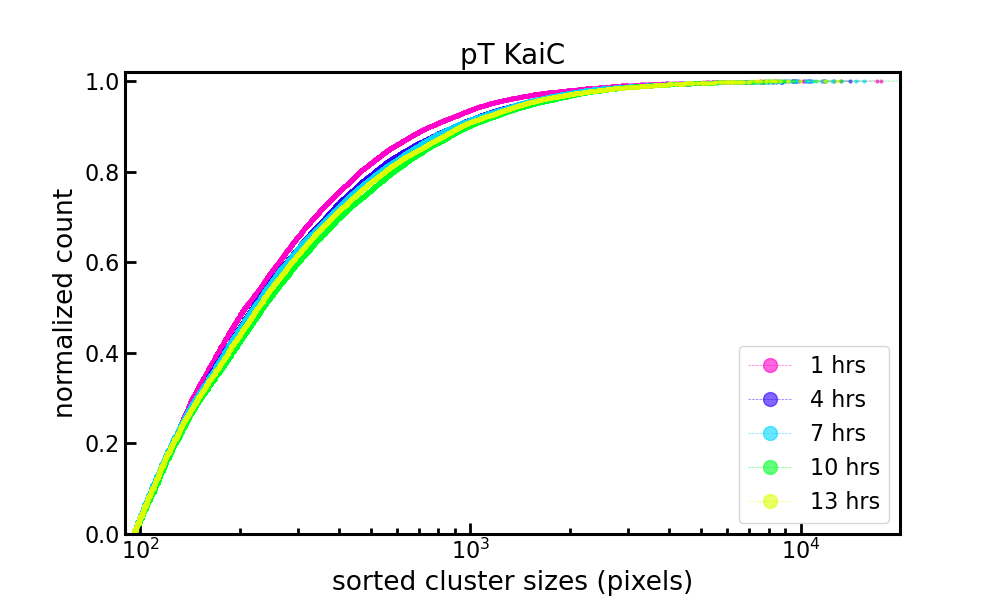

AE
[[222.  251.  249.  289.  297.  329.  334.  355.  367. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [272.  355.  379.  427.  484.  481.  517.5 566.5 543. ]
 [208.  219.  220.  235.  227.  238.  243.  240.  247. ]]


In [998]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

ax.set_xscale("log")
marker = '--o'
markerSize = 2
linew = 0.5
alpha_num = 0.6

fk = 3

cmap, all_t_clusters, data_label = select_cmap(fk)
cmap = matplotlib.cm.get_cmap('gist_rainbow') 
for i in range(5):
    time = str(time_array[i])+" hrs"
    x_data = sorted(all_t_clusters[i])
    N = len(x_data)
    y_data = (np.linspace(1,N,N))/N
    ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap(0.99-(i*0.187)), alpha=alpha_num, label = time)
    cSize_at_half = np.interp(0.5, y_data,x_data)
    all_cSize_at_half[fk][i] = (cSize_at_half)*(pixel_size**2)
print(all_cSize_at_half)
ax.set_xlim(90, 2e4)
ax.set_ylim(0, 1.02)
    
time = time_array[time_key]
title =  data_label #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('normalized count', fontsize=font_size-1)
plt.xlabel('sorted cluster sizes (pixels)', fontsize=font_size-1)
ax.legend(markerscale=5., fontsize=font_size-4, loc = 'lower right')
plt.show()
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"
title =  data_label + " (normalized CDF)"
fig.savefig(data_saveto+ "logx "+title+".png", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


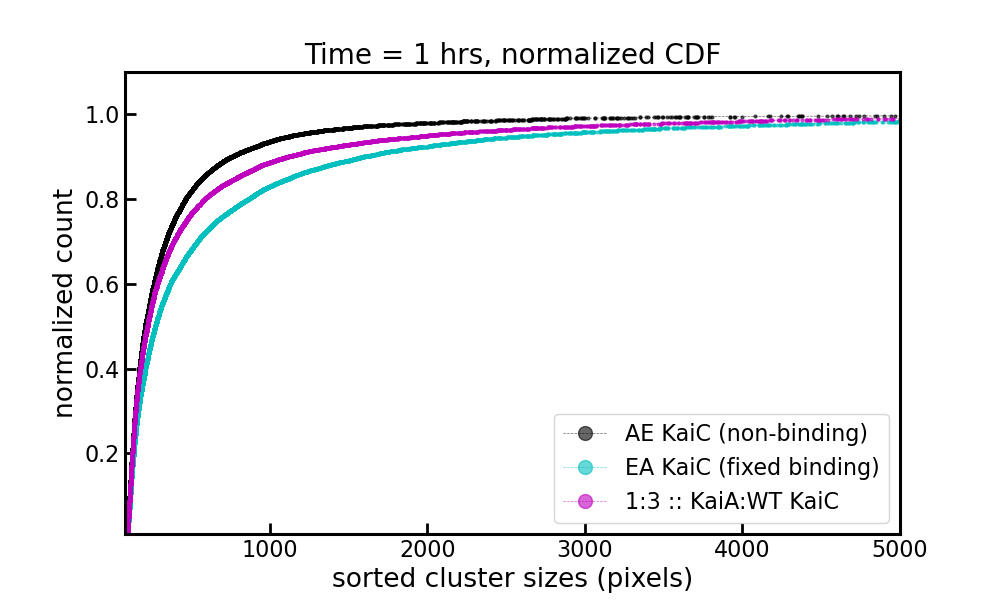

AE
EA
WT+kaiA


In [945]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

#ax.set_yscale("log")
#ax.set_xscale("log")
marker = '--o'
markerSize = 2
linew = 0.5
alpha_num = 0.6

time_key = 0

fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = sorted(all_t_clusters[time_key])
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = sorted(all_t_clusters[time_key])
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
x_data = sorted(all_t_clusters[time_key])
N = len(x_data)
y_data = (np.linspace(1,N,N))/N
ax.plot(x_data, y_data,marker, linewidth=linew, ms=markerSize, c=cmap, alpha=alpha_num, label = data_label)

#ax.set_xlim(80, 2.5*10e4)
ax.set_xlim(80, 5*10e2)

ax.set_ylim(10e-3, 1.1)

time = "Time = "+str(time_array[time_key])+" hrs"
title =  time + ", normalized CDF"  #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('normalized count', fontsize=font_size-1)
plt.xlabel('sorted cluster sizes (pixels)', fontsize=font_size-1)
ax.legend(markerscale=5., fontsize=font_size-4)
plt.show()

fig.savefig(data_saveto+ "logy AE, EA, WTkA - "+title+".png", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


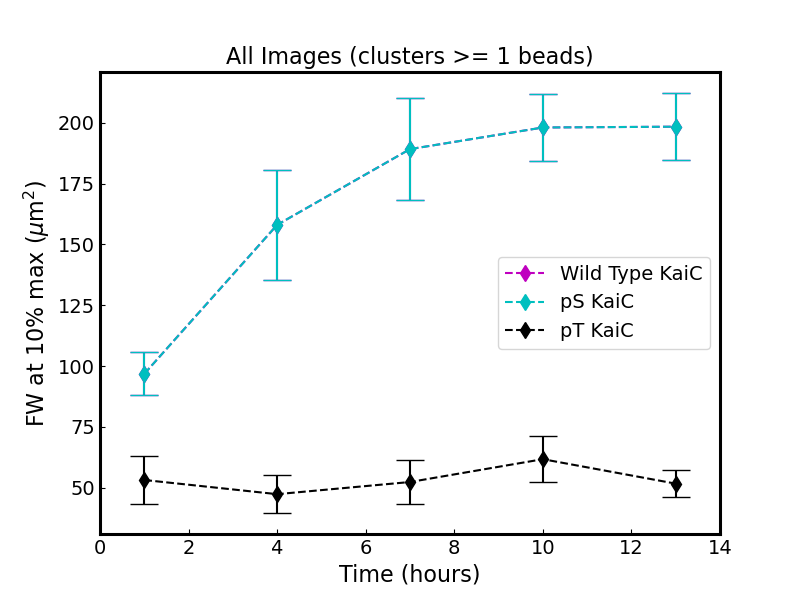

WT+kaiA
EA
AE


In [1032]:
%matplotlib notebook
cmap_num = (num_times*2) - 2
fig, ax = plt.subplots(figsize=(8,6))

this_plot = 'FW at 10% max ($\mu$m$^{{2}}$)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max'
this_plot_s = this_plot.split(' ')[0] + " " + this_plot.split(' ')[2]
#ax.set_xlim(0, 20)
#this_plot_s = '0-14_' + this_plot.split(' ')[0] + " " + this_plot.split(' ')[1]
#ax.set_ylim(2, 21)

end_index = 5
y_array = all_FWs  #all_nums[fk,i], all_means[fk,i], all_medians[fk,i], all_modes[fk,i], all_FWs[fk,i]
y_stdE = FWs_stdE   #nums_stdE[fk,i],means_stdE[fk,i],medians_stdE[fk,i],modes_stdE[fk,i],FWs_stdE[fk,i]
s_time_array = time_array[:end_index]

ax.set_xlim(0, 14)
marker = '--d'
markerSize = 8
font_size = 16
cmap_num = 0.6
threshold_details = " (clusters >= "+str(beads_per_cluster)+" beads)"
title = "All Images" + threshold_details

ax.set_title(title, fontsize= (font_size))
plt.ylabel(this_plot, fontsize=font_size)
plt.xlabel('Time (hours)', fontsize=font_size)
ax.tick_params(axis='both', direction='in', which='major', labelsize=font_size-2)
ax.tick_params(axis='both', direction='in', which='minor', labelsize=font_size-2)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk][:end_index],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk][:end_index], yerr = (y_stdE[fk][:end_index]), fmt = 'none', ecolor=cmap, capsize=10)
fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk][:end_index],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk][:end_index], yerr = (y_stdE[fk][:end_index]), fmt = 'none', ecolor=cmap, capsize=10)
fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk][:end_index],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk][:end_index], yerr = (y_stdE[fk][:end_index]), fmt = 'none', ecolor=cmap, capsize=10)

plt.show()
ax.legend(fontsize=font_size-2)
threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
#fig.savefig(data_saveto+this_plot_s+threshold_details+".jpg", dpi=dpi_num)
#fig.savefig(data_saveto+this_plot+threshold_details+".jpg", dpi=dpi_num)

In [782]:
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

<IPython.core.display.Javascript object>


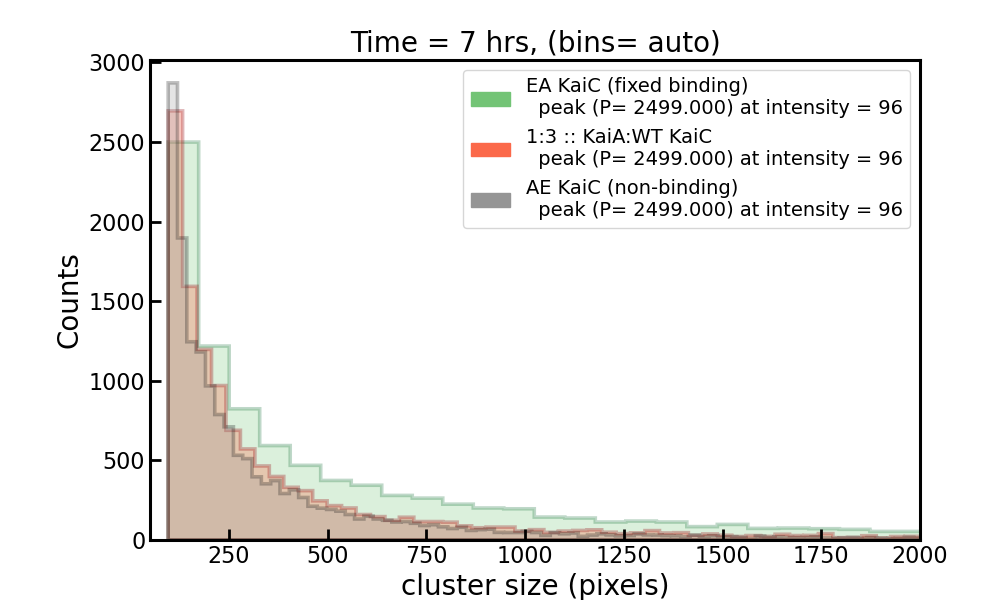

EA
1756
WT+kaiA
1362
AE
657


In [812]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
#ax.set_yscale("log")
msize = 0.11
linew = 2.6
cmap_num = 0.5  #0.99-((time_key-add)*0.11)
alpha_num = -0.05 #0.02*time_key + add/10

time_key = 2
bins_num = 'auto' #1000
time = time_array[time_key]
title = "Time = " + str(time) + " hrs, (bins= " + str(bins_num) + ")"

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=False, bins=bins_num, stacked=True, 
                          alpha=0.3 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
print(len(counts))
color0=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text0= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch0 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=False, bins=bins_num, stacked=True, 
                          alpha=0.35 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
print(len(counts))
color1=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text1= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch1 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=False, bins=bins_num, stacked=True, 
                          alpha=0.3 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.49), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
print(len(counts))
color2=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text2= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch2 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

xmin, xmax = plt.xlim()
yticks = ax.get_yticklabels()

#for ax in axes:
ax.tick_params(color='black', labelcolor='black')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
plt.ylabel('Counts', fontsize=font_size)
ax.yaxis.labelpad = 4
plt.xlabel('cluster size (pixels)', fontsize=font_size)
#plt.ylim(0.000001, 0.012)
#plt.ylim(0.000001, 0.00266)
#plt.xlim(400, 5500)  # t8-> 142000, t7-> 128000, t6-> 97000 t5-> 103000 t4-> 
#plt.xlim(400, 15000)
plt.xlim(50, 2000)
#plt.xlim(50, 20000)
#plt.ylim(0.000001, 0.00266)
plt.title(title, fontsize=font_size)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.92, top=0.9)

ax.legend(handles=[patch0, patch1, patch2], markerscale=2., fontsize=font_size-6)
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"

plt.show()
fig.savefig(data_saveto+ "AE, EA, WTkA, "+ " (1 bead min) clustersize histograms- "+title+".png", dpi=800, bbox_inches ='tight')

In [546]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.2 #set the value globally

<IPython.core.display.Javascript object>


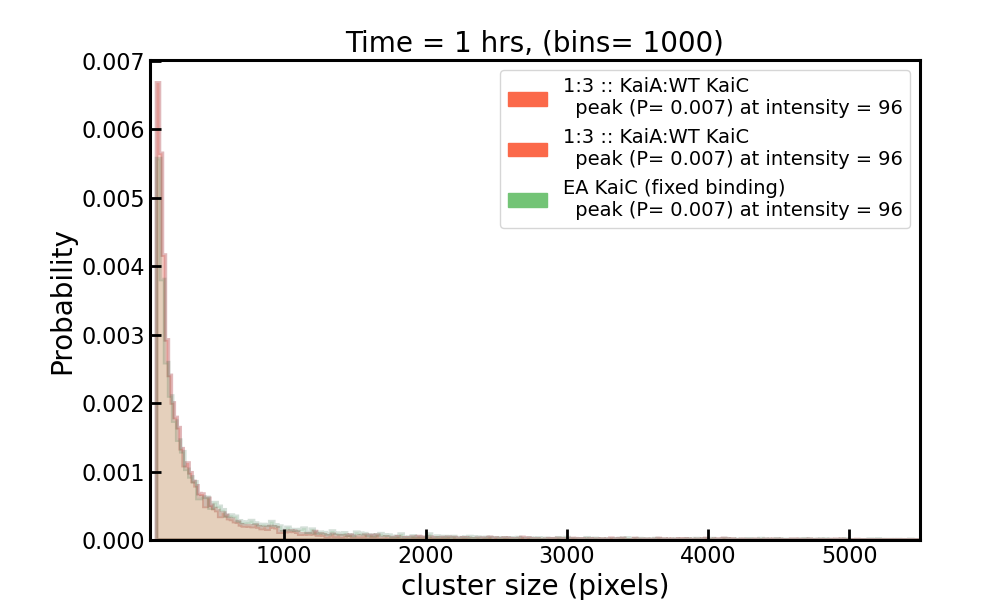

WT+kaiA
WT+kaiA
EA


In [734]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
#ax.set_yscale("log")
msize = 0.11
linew = 2.6
cmap_num = 0.5  #0.99-((time_key-add)*0.11)
alpha_num = -0.18 #0.02*time_key + add/10

time_key = 0
bins_num = 1000
time = time_array[time_key]
title = "Time = " + str(time) + " hrs, (bins= " + str(bins_num) + ")"

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                          alpha=0.3 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
#print(counts)
color0=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text0= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch0 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                          alpha=0.37 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.4), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
#print(counts)
color1=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text1= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch1 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
counts, bins, bars = ax.hist(all_t_clusters[time_key], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                          alpha=0.35 + alpha_num, color=cmap(cmap_num), edgecolor=cmap(cmap_num+0.49), linewidth=linew) 
#ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(cmap_num) )
#print(counts)
color2=cmap(cmap_num)
max_bin = bins[np.argmax(counts)]
max_prob = counts.max()
text2= "  peak (P= {:.3f}) at intensity = {:.0f}".format(max_prob, max_bin)
patch2 = mpatches.Patch(color=cmap(cmap_num), label=data_label + "\n" + text0)

xmin, xmax = plt.xlim()
yticks = ax.get_yticklabels()

#for ax in axes:
ax.tick_params(color='black', labelcolor='black')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
plt.ylabel('Probability', fontsize=font_size)
ax.yaxis.labelpad = 4
plt.xlabel('cluster size (pixels)', fontsize=font_size)
#plt.ylim(0.000001, 0.012)
#plt.ylim(0.000001, 0.00266)
#plt.xlim(400, 5500)  # t8-> 142000, t7-> 128000, t6-> 97000 t5-> 103000 t4-> 
#plt.xlim(400, 15000)
plt.xlim(50, 5500)
#plt.ylim(0.000001, 0.00266)
plt.title(title, fontsize=font_size)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.92, top=0.9)

ax.legend(handles=[patch0, patch1, patch2], markerscale=2., fontsize=font_size-6)
if data_label == "1:3 :: KaiA:WT KaiC":
    data_label = "WT + KaiA"

plt.show()
#fig.savefig(data_saveto+ "AE, EA, WTkA, "+ " logy clustersize histograms- "+title+".png", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


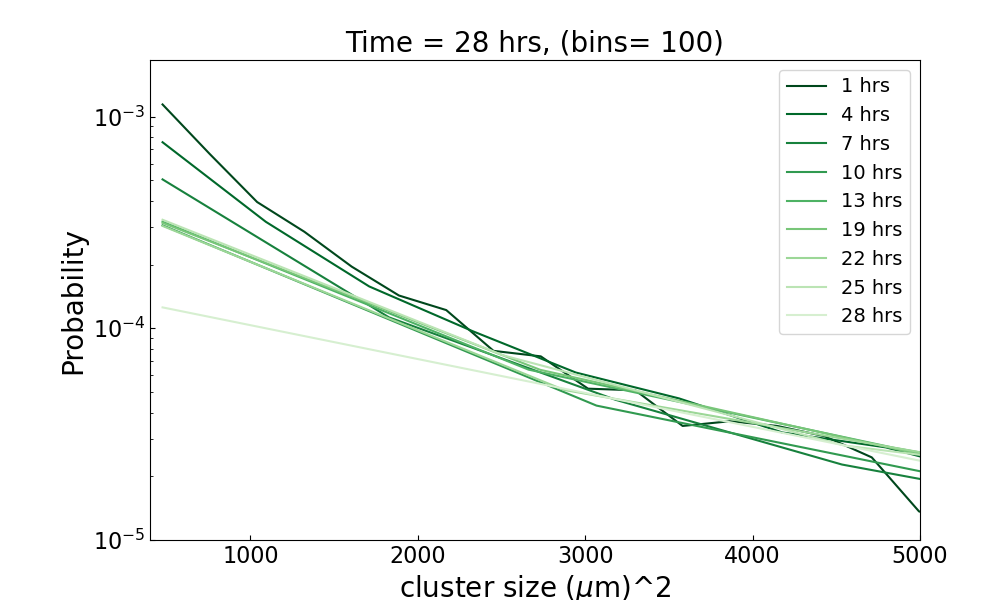

EA


In [450]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', direction='in', which='major', labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', labelsize=font_size-4)
ax.set_yscale("log")
msize = 0.11

time_key = 8
bins_num = 100
time = time_array[time_key]
title = "Time = " + str(time) + " hrs, (bins= " + str(bins_num) + ")"

linew = 1.5
cmap_num = 10  #0.99-((time_key-add)*0.11)  (0.18+(i*0.1))
 #0.02*time_key + add/10

fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
for i in range(num_times):
    time = str(time_array[i])+" hrs"
    alpha_num = 0
    counts, bins = np.histogram(all_t_clusters[i], bins=bins_num, density = True)
    #counts, bins, bars = ax.hist(all_t_clusters[i], histtype="stepfilled", density=True, bins=bins_num, stacked=True, 
                         # alpha=0.2+ alpha_num, color=cmap(0.18+(i*0.1)), label=time )

    ax.plot(bins[:-1], counts,'-', linewidth=linew, ms=msize, alpha=1, color=cmap(0.99-(i/cmap_num)), label=time )

xmin, xmax = plt.xlim()
yticks = ax.get_yticklabels()

    
plt.ylabel('Probability', fontsize=font_size)
ax.yaxis.labelpad = 4
plt.xlabel('cluster size ($\mu$m)^2', fontsize=font_size)
plt.ylim(0.00001, 0.00185)
#plt.ylim(0, 0.00185)
plt.xlim(400, 5000)
#plt.xlim(0, 3000)
#plt.xlim(300, 20000)
plt.title(title, fontsize=font_size)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.92, top=0.9)

ax.legend(markerscale=2., fontsize=font_size-6)

plt.show()
#fig.savefig(data_saveto+"EA, AE, WT clustersize histograms- "+title+".png", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


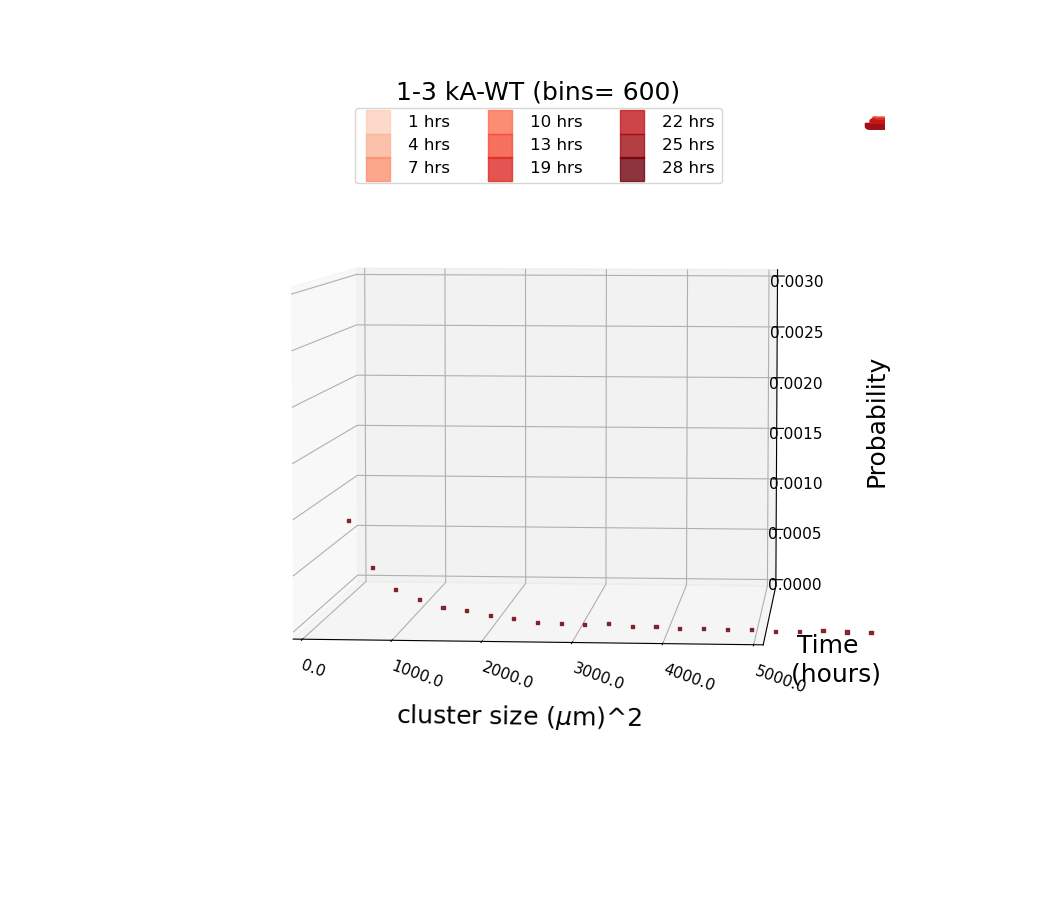

WT+kaiA


<ipython-input-428-6f631bf19479>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = -20, ha="left", fontsize = font_size-7)


In [428]:
fig = plt.figure(figsize=(10.5,9))
ax = fig.add_subplot(projection='3d')
font_size = 18
ax.tick_params(axis='both', which='major', labelsize=font_size-7)
msize = 5.0


frame_key = 0
condition = frame_names[frame_key]
cmap, all_t_clusters, data_label = select_cmap(fk)
title = frame_names[frame_key] +" (bins= "+str(bins_num)+")"
all_counts = np.zeros((num_times, bins_num))
all_bins = np.zeros((num_times, bins_num))

zmin = 0.000001
linew = 1.5
add = 0
cmap_num = 16#0.6  #0.99-((time_key-add)*0.11)  (0.99-(i/cmap_num))
alpha_num = 0.8  #0.02*time_key + add/10
yticks = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for i in range(num_times):
    time = str(time_array[i])+" hrs"
    counts, bins = np.histogram(all_t_clusters[i], bins=bins_num, density=True)
    ax.scatter(bins[:-1], counts, zs=(8-i), zdir='y', s=msize, marker='s', color=cmap(0.18+(i*0.1)),
               alpha=alpha_num, label=time)
    #counts, bins, bars = ax.hist(all_times_all_values[i], histtype="stepfilled", density=True, 
                                # bins=bins_num, stacked=True, alpha=alpha_num, color=cmap(0.99-(i*0.11)), label=time)

    
'''    counts, bins = np.histogram(pixel_vals[i], bins=bins_num, density = True)
    full_width, half_max, peak = FWHM(bins[:-1], counts)
    logscaled_counts = manual_log_scale(counts, zmin)
    ax.scatter(bins[:-1], logscaled_counts, zs=(8-i), zdir='y', s=msize, marker='s', color=cmap(0.18+(i*0.1)), 
               alpha=alpha_num, label=time) '''

ax.set_xlabel('cluster size ($\mu$m)^2', fontsize=font_size)
#ax.set_ylabel('time (hours)', fontsize=font_size, labelpad= 7.0)
#ax.set_zscale("log")

ax.xaxis.labelpad = 25
ax.zaxis.labelpad = 40
ax.set_xlim(0, 5000)
ax.set_zlim(0, 0.003)

#zaxis_log_labels = ['0.00001', '0.0001', '0.001', '0.01']
#zaxis_log_labels = ["$\mathregular{10^{-6}}$","$\mathregular{10^{-5}}$", "$\mathregular{10^{-4}}$", "$\mathregular{10^{-3}}$", "$\mathregular{10^{-2}}$"]
#zaxis_log_ticks = [0.000001, 0.00001, 0.0001, 0.001, 0.01] #0.00001, 0.0001, 0.001, 0.01
#new_zticks = [0, 2.30258509, 4.60517019, 6.90775528, 9.21034037] #0, 2.30258509, 4.60517019, 6.90775528


#['1', '4', '7', '10', '13', '19', '22', '25', '28']

# On the y axis let's only label the discrete values that we have data for.
ax.set_xticklabels(ax.get_xticks(), rotation = -20, ha="left", fontsize = font_size-7)

#ax.set_zticks([])
#ax.set_zticks(new_zticks)
#ax.set_zticklabels(zaxis_log_labels, ha='right', va='bottom')
#ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
#ax.ticklabel_format(useOffset=True)

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks([])
#ax.set_yticks(yticks)
#ax.set_yticklabels(['28', '25', '22', '19', '13', '10', '7', '4', '1']) #
#ax.set_yticklabels(['1', '4', '7', '10', '13', '19', '22', '25', '28'])
#ax.set_yticklabels(ax.yaxis.get_majorticklabels(), ha='left', va='bottom')

ax.yaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_ylabel('Time \n (hours)', rotation = 0, fontsize=font_size, labelpad= 15.0, ha="left", va='top')
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Probability', rotation = 90, fontsize=font_size, ha="right")

ax.set_title(title, fontsize=font_size)
ax.view_init(elev=5., azim=-85)
ax.legend(markerscale=8., loc="upper center",ncol=3, borderaxespad=0, fontsize=font_size-6) #bbox_to_anchor=(0.06, 0.5)
#fig = plt.gcf()
#fig.tight_layout()
plt.show()
#fig.savefig(data_saveto+"new logy 3D histograms all times - "+title+".png", dpi=600)

In [ ]:
### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(fig_size))
gs = fig.add_gridspec(4, top=0.95, hspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = condition +" results (clusters= at least "+str(beads_per_cluster)+" beads)"

for i in range(int(len(time_array))):
    axs[0].set_title(title, fontsize= (font_size))
    axs[0].set( ylabel='clusters found (number)')
    #axs[0].set_ylim(0, 400)
    axs[0].plot(time_array[i], avg_total_num[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "max cluster size")
    axs[0].errorbar(time_array[i], avg_total_num[i], yerr = stderror_total_num[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='mean cluster size ($\mu$m)^2')
    #axs[1].set_ylim(0, 60)
    axs[1].plot(time_array[i], avg_mean_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[1].errorbar(time_array[i], avg_mean_size[i], yerr = stderror_mean_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set( ylabel='median cluster size ($\mu$m)^2')
    #axs[2].set_ylim(0, 60)
    axs[2].plot(time_array[i], avg_median_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[2].errorbar(time_array[i], avg_median_size[i], yerr = stderror_median_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[3].set( ylabel='mode cluster size ($\mu$m)^2')
    axs[3].set( xlabel="Time (hrs after adding KaiC)")
    #axs[3].set_ylim(0, 30)
    axs[3].plot(time_array[i], avg_mode_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[3].errorbar(time_array[i], avg_mode_size[i], yerr = stderror_mode_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)

#plt.subplot_tool()
plt.show()
fig.savefig(saveto_dir+title+".jpg", dpi=dpi_num)

In [55]:
csv_data_file = exp+"-- results (clusters= at least "+str(beads_per_cluster)+" beads)"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','','','','','',
                         'mean cluster size','','','','','','','','','',
                         'median cluster size','','','','','','','','',
                         'mode cluster size',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], row4_results[i][0],
                             row5_results[i][0], row6_results[i][0], avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], row4_results[i][1], 
                             row5_results[i][1], row6_results[i][1], avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], row4_results[i][2], 
                             row5_results[i][2], row6_results[i][2], avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], row4_results[i][3], 
                             row5_results[i][3], row6_results[i][3], avg_mode_size[i], stderror_mode_size[i],'',])
        writer.writerow([''])
        
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','','','','','',
                         'mean cluster size','','','','','','','','','',
                         'median cluster size','','','','','','','','',
                         'mode cluster size',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',
                         'row1','row2','row3','row4','row5','row6','avg','std error','',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], row4_results[i][0],
                             row5_results[i][0], row6_results[i][0], avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], row4_results[i][1], 
                             row5_results[i][1], row6_results[i][1], avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], row4_results[i][2], 
                             row5_results[i][2], row6_results[i][2], avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], row4_results[i][3], 
                             row5_results[i][3], row6_results[i][3], avg_mode_size[i], stderror_mode_size[i],'',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.


In [56]:
csv_data_file = exp+"--BP results (clusters= at least "+str(beads_per_cluster)+" beads)"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        
        writer.writerow(['row4',row4_results[1][0],row4_results[2][0],row4_results[3][0],row4_results[4][0],row4_results[5][0],
                         row4_results[6][0],row4_results[7][0],row4_results[8][0],row4_results[i][0],'','',
                         'row4',row4_results[1][1],row4_results[2][1],row4_results[3][1],row4_results[4][1],row4_results[5][1],
                         row4_results[6][1],row4_results[7][1],row4_results[8][1],row4_results[i][1],'','',
                         'row4',row4_results[1][2],row4_results[2][2],row4_results[3][2],row4_results[4][2],row4_results[5][2],
                         row4_results[6][2],row4_results[7][2],row4_results[8][2],row4_results[i][2],'','',
                         'row4',row4_results[1][3],row4_results[2][3],row4_results[3][3],row4_results[4][3],row4_results[5][3],
                         row4_results[6][3],row4_results[7][3],row4_results[8][3],row4_results[i][3],'','',])
        
        writer.writerow(['row5',row5_results[1][0],row5_results[2][0],row5_results[3][0],row5_results[4][0],row5_results[5][0],
                         row5_results[6][0],row5_results[7][0],row5_results[8][0],row5_results[i][0],'','',
                         'row5',row5_results[1][1],row5_results[2][1],row5_results[3][1],row5_results[4][1],row5_results[5][1],
                         row5_results[6][1],row5_results[7][1],row5_results[8][1],row5_results[i][1],'','',
                         'row5',row5_results[1][2],row5_results[2][2],row5_results[3][2],row5_results[4][2],row5_results[5][2],
                         row5_results[6][2],row5_results[7][2],row5_results[8][2],row5_results[i][2],'','',
                         'row5',row5_results[1][3],row5_results[2][3],row5_results[3][3],row5_results[4][3],row5_results[5][3],
                         row5_results[6][3],row5_results[7][3],row5_results[8][3],row5_results[i][3],'','',])
        
        writer.writerow(['row6',row6_results[1][0],row6_results[2][0],row6_results[3][0],row6_results[4][0],row6_results[5][0],
                         row6_results[6][0],row6_results[7][0],row6_results[8][0],row6_results[i][0],'','',
                         'row6',row6_results[1][1],row6_results[2][1],row6_results[3][1],row6_results[4][1],row6_results[5][1],
                         row6_results[6][1],row6_results[7][1],row6_results[8][1],row6_results[i][1],'','',
                         'row6',row6_results[1][2],row6_results[2][2],row6_results[3][2],row6_results[4][2],row6_results[5][2],
                         row6_results[6][2],row6_results[7][2],row6_results[8][2],row6_results[i][2],'','',
                         'row6',row6_results[1][3],row6_results[2][3],row6_results[3][3],row6_results[4][3],row6_results[5][3],
                         row6_results[6][3],row6_results[7][3],row6_results[8][3],row6_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        
        writer.writerow(['row4',row4_results[1][0],row4_results[2][0],row4_results[3][0],row4_results[4][0],row4_results[5][0],
                         row4_results[6][0],row4_results[7][0],row4_results[8][0],row4_results[i][0],'','',
                         'row4',row4_results[1][1],row4_results[2][1],row4_results[3][1],row4_results[4][1],row4_results[5][1],
                         row4_results[6][1],row4_results[7][1],row4_results[8][1],row4_results[i][1],'','',
                         'row4',row4_results[1][2],row4_results[2][2],row4_results[3][2],row4_results[4][2],row4_results[5][2],
                         row4_results[6][2],row4_results[7][2],row4_results[8][2],row4_results[i][2],'','',
                         'row4',row4_results[1][3],row4_results[2][3],row4_results[3][3],row4_results[4][3],row4_results[5][3],
                         row4_results[6][3],row4_results[7][3],row4_results[8][3],row4_results[i][3],'','',])
        
        writer.writerow(['row5',row5_results[1][0],row5_results[2][0],row5_results[3][0],row5_results[4][0],row5_results[5][0],
                         row5_results[6][0],row5_results[7][0],row5_results[8][0],row5_results[i][0],'','',
                         'row5',row5_results[1][1],row5_results[2][1],row5_results[3][1],row5_results[4][1],row5_results[5][1],
                         row5_results[6][1],row5_results[7][1],row5_results[8][1],row5_results[i][1],'','',
                         'row5',row5_results[1][2],row5_results[2][2],row5_results[3][2],row5_results[4][2],row5_results[5][2],
                         row5_results[6][2],row5_results[7][2],row5_results[8][2],row5_results[i][2],'','',
                         'row5',row5_results[1][3],row5_results[2][3],row5_results[3][3],row5_results[4][3],row5_results[5][3],
                         row5_results[6][3],row5_results[7][3],row5_results[8][3],row5_results[i][3],'','',])
        
        writer.writerow(['row6',row6_results[1][0],row6_results[2][0],row6_results[3][0],row6_results[4][0],row6_results[5][0],
                         row6_results[6][0],row6_results[7][0],row6_results[8][0],row6_results[i][0],'','',
                         'row6',row6_results[1][1],row6_results[2][1],row6_results[3][1],row6_results[4][1],row6_results[5][1],
                         row6_results[6][1],row6_results[7][1],row6_results[8][1],row6_results[i][1],'','',
                         'row6',row6_results[1][2],row6_results[2][2],row6_results[3][2],row6_results[4][2],row6_results[5][2],
                         row6_results[6][2],row6_results[7][2],row6_results[8][2],row6_results[i][2],'','',
                         'row6',row6_results[1][3],row6_results[2][3],row6_results[3][3],row6_results[4][3],row6_results[5][3],
                         row6_results[6][3],row6_results[7][3],row6_results[8][3],row6_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.
